# CS 109A/AC 209A/STAT 121A Data Science: Final Project
**Harvard University**<br>
**Fall 2016**<br>
**Instructors:** W. Pan, P. Protopapas, K. Rader<br>
**Members: ** Shawn Pan, Xinyuan (Amy) Wang, Ming-long Wu

## Remark - 043_reduce_dim.ipynb ##
- Check if PCA for dimension reduction is helpfu.


In [58]:
import time
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import savgol_filter
from scipy.stats import mode
import goslate
from langdetect import detect
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib import colors
import matplotlib.dates as mdates
from datetime import datetime
from collections import Counter
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm
from sklearn import preprocessing
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

### Load data

In [31]:
# Load listing data
listing = pd.read_csv('../../Data/data_preprocessed.csv')
print(listing.columns.values)
listing.head()

['id' 'host_since' 'zipcode' 'latitude' 'longitude' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'guests_included' 'minimum_nights'
 'maximum_nights' 'availability_30' 'availability_60' 'availability_90'
 'availability_365' 'number_of_reviews' 'first_review' 'last_review'
 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'host_listing_count' 'price' 'property_type_0'
 'property_type_1' 'property_type_2' 'property_type_3' 'property_type_4'
 'property_type_5' 'room_type_0' 'room_type_1' 'room_type_2' 'bed_type_0'
 'bed_type_1' 'bed_type_2' 'bed_type_3' 'bed_type_4']


,id,host_since,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,...,property_type_4,property_type_5,room_type_0,room_type_1,room_type_2,bed_type_0,bed_type_1,bed_type_2,bed_type_3,bed_type_4
0,1069266,1926,10022.0,40.756852,-73.964754,2,1.0,1.0,1.0,2,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1846722,1625,10530.0,40.830599,-73.941014,10,1.0,3.0,3.0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2061725,1831,11221.0,40.692189,-73.924120,2,1.0,1.0,2.0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,44974,953,10011.0,40.734751,-74.002592,2,1.0,1.0,1.0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4701675,2479,10011.0,40.745282,-73.997836,2,1.0,1.0,2.0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Check scatter plots of several predictor matrix
- **None of the pair checked has high correlation.**

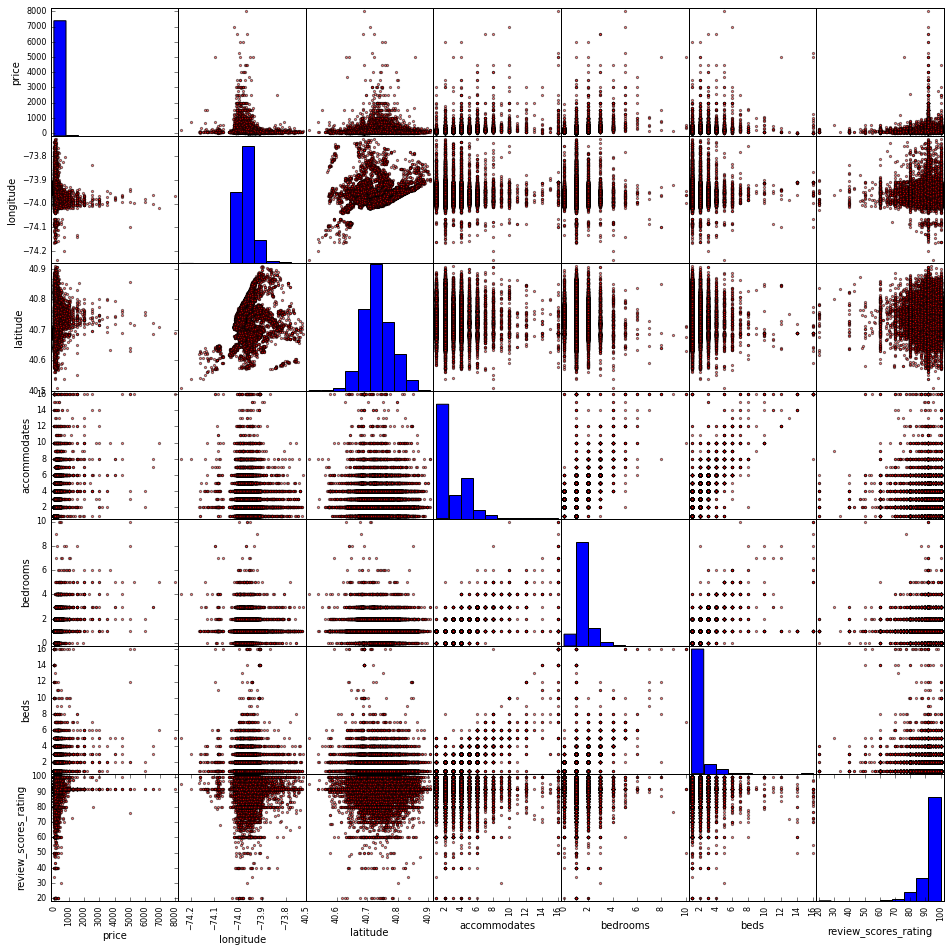

In [32]:
# Scatter plot of several predictors
scattercols = ['price','longitude','latitude','accommodates','bedrooms','beds','review_scores_rating']
axs = pd.scatter_matrix(listing[scattercols],
figsize=(16, 16), c='red')

### Principal Component Analysis for dimension reduction ###
- Performs PCA by checking variance explained.

In [33]:
# Get x and y
x = listing
x = x.drop('price', axis=1)
x = x.drop('id', axis=1)
y = listing['price']
print x.shape
print y.shape

(27392, 40)
(27392,)


In [34]:
# Apply PCA to data and get the top 150 axes of maximum variation
num_com = x.shape[1]
pca = PCA(n_components=num_com)
pca.fit(x)


PCA(copy=True, n_components=40, whiten=False)

In [35]:
pca.explained_variance_ratio_

array([  9.99999998e-01,   9.55618704e-10,   7.14469270e-10,
         1.75143445e-10,   4.56610029e-11,   3.43084481e-11,
         1.88127397e-12,   5.54130303e-13,   1.30159853e-13,
         9.46325161e-14,   1.82678641e-14,   1.71436364e-14,
         1.53584795e-14,   1.06026186e-14,   1.96807770e-15,
         1.59789567e-15,   1.43649616e-15,   1.17361376e-15,
         1.06436043e-15,   8.51743460e-16,   8.04330190e-16,
         6.14317021e-16,   5.81217915e-16,   4.02584250e-16,
         3.16545950e-16,   2.45136747e-16,   1.57486783e-16,
         8.78957579e-17,   7.93699155e-17,   3.76019199e-17,
         2.30975514e-17,   2.21061108e-17,   1.11341330e-17,
         1.01921029e-17,   5.10904369e-18,   5.06709557e-18,
         1.11667692e-18,   9.98373155e-33,   9.98373155e-33,
         9.98373155e-33])

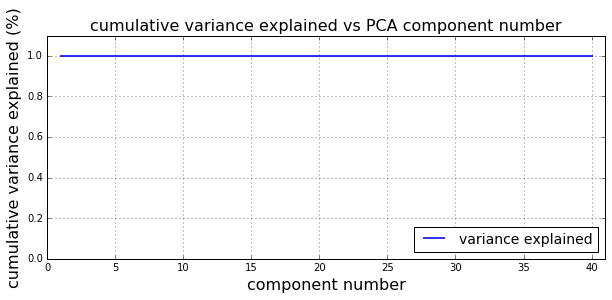

In [36]:
variance_cumulative = np.empty(num_com)
for idx in range(num_com):
    variance_cumulative[idx] = sum(pca.explained_variance_ratio_[0:idx+1])

# Plot weekday average price in 2015
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.plot(range(1,num_com+1),variance_cumulative, c='blue', label='variance explained', linewidth=2.0, alpha = 0.8)
ax1.set_xlabel('component number', fontsize=16)
ax1.set_ylabel('cumulative variance explained (%)', fontsize=16)
ax1.set_title('cumulative variance explained vs PCA component number', fontsize=16)
ax1.set_xlim([0,41])
ax1.set_ylim([0,1.1])
plt.legend(loc = 4, fontsize = 14)
plt.grid()
plt.show()

**Here, we see that the first component already explained 99.9% variance. We could have chosen just one component in PCA here. But we emperically choose top three components to be more inclusive.**

In [54]:
# Apply PCA to data and get the top 3 axes of maximum variation
num_com = 3
pca = PCA(n_components=num_com)
pca.fit(x)
print('Total variance explained: ' + str(sum(pca.explained_variance_ratio_[0:num_com])) + '%')

# Project to the data onto the three axes
x_pca = pca.transform(x)
print('Reduced x dimension:' + str(x_pca.shape))

Total variance explained: 0.999999999742%
Reduced x dimension:(27392, 3)


### Split PCA reduced data for training and testing data###

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, np.log(y), test_size=0.3, random_state=0)

In [56]:
#OLS
X = sm.add_constant(x_train)
model = sm.OLS(y_train,X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     872.2
Date:                Wed, 14 Dec 2016   Prob (F-statistic):               0.00
Time:                        19:01:38   Log-Likelihood:                -17426.
No. Observations:               19174   AIC:                         3.486e+04
Df Residuals:                   19170   BIC:                         3.489e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.8870      0.004   1126.884      0.0

In [61]:
#same OLS model with sklearn (easier to score but less detailed output)
#fit LinearModel after StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

modelstd = Pipeline([
            ("normalize", StandardScaler()),
            ("LinearModel", LinearRegression())
        ])

modelstd.fit(x_train, y_train)
print "Train Score", modelstd.score(x_train, y_train)
print "Test Score", modelstd.score(x_test, y_test)


 Train Score 0.120100710497
Test Score 0.118438992869


### Conclusion: PCA is not very helpful here. ###